In [4]:
import numpy as np
import pandas as pd
from scipy import stats

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline 

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set(font_scale=1.5)

In [5]:
# Python version
import sys
print('Python: {}'.format(sys.version))
# scipy
import scipy
print('scipy: {}'.format(scipy.__version__))
# numpy
import numpy
print('numpy: {}'.format(numpy.__version__))
# matplotlib
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
# pandas
import pandas
print('pandas: {}'.format(pandas.__version__))

Python: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.1


- An Analysis of Variance Test or an ANOVA is a generalization of the t-tests to more than 2 groups. 
- Our null hypothesis states that there are __equal means__ in the populations from which the groups of data were sampled. 

- More succinctly:

$𝜇_1 = 𝜇_2 = ... = 𝜇_𝑛$
for 𝑛 groups of data. 

- Our alternative hypothesis would be that any one of the equivalences in the above equation fail to be met.

In [6]:
location = r"E:\MYLEARN\2-ANALYTICS-DataScience\datasets\scores.csv"

In [7]:
data = pd.read_csv(location)
data.head()

,School ID,School Name,Borough,Building Code,Street Address,City,State,Zip Code,Latitude,Longitude,...,End Time,Student Enrollment,Percent White,Percent Black,Percent Hispanic,Percent Asian,Average Score (SAT Math),Average Score (SAT Reading),Average Score (SAT Writing),Percent Tested
0,02M260,Clinton School Writers and Artists,Manhattan,M933,425 West 33rd Street,Manhattan,NY,10001,40.75321,-73.99786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06M211,Inwood Early College for Health and Informatio...,Manhattan,M052,650 Academy Street,Manhattan,NY,10002,40.86605,-73.92486,...,3:00 PM,87.0,3.4%,21.8%,67.8%,4.6%,NaN,NaN,NaN,NaN
2,01M539,"New Explorations into Science, Technology and ...",Manhattan,M022,111 Columbia Street,Manhattan,NY,10002,40.71873,-73.97943,...,4:00 PM,1735.0,28.6%,13.3%,18.0%,38.5%,657.0,601.0,601.0,91.0%
3,02M294,Essex Street Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,2:45 PM,358.0,11.7%,38.5%,41.3%,5.9%,395.0,411.0,387.0,78.9%
4,02M308,Lower Manhattan Arts Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,...,3:00 PM,383.0,3.1%,28.2%,56.9%,8.6%,418.0,428.0,415.0,65.1%


In [8]:
data['Borough'].value_counts()

Brooklyn         121
Bronx            118
Manhattan        106
Queens            80
Staten Island     10
Name: Borough, dtype: int64

Creating New Columns
There is no total score column, so we'll have to create it. In addition, we'll have to find the mean score of the each district across all schools.

In [9]:
data['total_score'] = data['Average Score (SAT Reading)'] +  \
                      data['Average Score (SAT Math)']    +  \
                      data['Average Score (SAT Writing)']
        
data = data[['Borough', 'total_score']].dropna()   

data.head()

,Borough,total_score
2,Manhattan,1859.0
3,Manhattan,1193.0
4,Manhattan,1261.0
5,Manhattan,1529.0
6,Manhattan,1197.0


In [10]:
data[data['Borough'] == 'Bronx']['total_score']

117    1164.0
118    1227.0
119    1202.0
120    1100.0
121    1203.0
        ...  
228    1165.0
230    1210.0
231    1273.0
232    1255.0
233    1192.0
Name: total_score, Length: 98, dtype: float64

In [11]:
x = ['Brooklyn', 'Bronx', 'Manhattan', 'Queens', 'Staten Island']

district_dict = {}

# Assigns each test score series to a dictionary key
for district in x:
    district_dict[district] = data[data['Borough'] == district]['total_score']


Brooklyn_std : 154.8684270520867
Bronx_std : 150.39390071890668
Manhattan_std : 230.2941395363782
Queens_std : 195.25289850192115
Staten Island_std : 222.30359621222706


Text(0, 0.5, 'Average Total SAT Score')

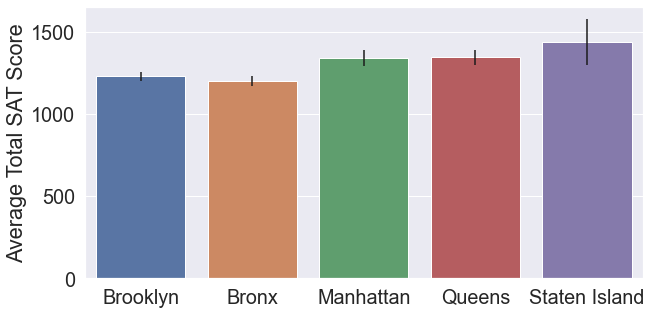

In [12]:
y = []
yerror = []

# Assigns the mean score and 95% confidence limit to each district
for district in x:
    y.append(district_dict[district].mean())
    
    yerror.append(1.96 * district_dict[district].std()/np.sqrt(district_dict[district].shape[0]))    
    
    print(district + '_std : {}'.format(district_dict[district].std()))
    
sns.set(font_scale=1.8)
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x, y, yerr=yerror)
ax.set_ylabel('Average Total SAT Score')

- average SAT scores are quite different for each district. 
- We are interested in knowing if this is caused by random variation in data, or if there is an underlying cause. 
- Since we have 5 different groups, we cannot use the t-test. 
- Also note that the standard deviation of each group are also very different, so we've violated one of our assumpions. 
- we are going to use the 1-way ANOVA test

__The Null hypothesis:-__
There are no significant differences between the groups' mean SAT scores.
$ H_0 : μ1=μ2=μ3=μ4=μ5$ 


__and Alternative Hypothesis :-__
There is a significant difference between the groups' mean SAT scores.
$H_A : μi≠μj$

Where μi and μj can be the mean of any group. 

If there is at least one group with a significant difference with another group, the null hypothesis will be rejected.

#### 1-way ANOVA
Similar to the t-test, we can calculate a score for the ANOVA. Then we can look up the score in the F-distribution and obtain a p-value.

_This is quite a lot of math, fortunately scipy has a function that plugs in all the values for us._ 

In [14]:
stats.f_oneway(
             district_dict['Brooklyn'], district_dict['Bronx'], \
             district_dict['Manhattan'], district_dict['Queens'], \
             district_dict['Staten Island']
)

F_onewayResult(statistic=12.733085029201668, pvalue=1.0161974965566023e-09)

The resulting pvalue was less than 0.05. We can reject the null hypothesis and conclude that there is a significant difference between the SAT scores for each district. 